# Multi-Agentic Recommendation System Pipeline
This notebook demonstrates a modular, multi-agentic pipeline for evaluating recommender systems with context engineering.

Each agent is responsible for a specific function, and context engineering is used to enhance the recommendation process.

In [1]:
# Go to root dir to load the code from `src` and dataset from the specific folder
import os
os.chdir("..")

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch

from scipy.sparse import lil_matrix

from prettytable import PrettyTable

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import Deduplicate, MinRating, MinItemsPerUser
from recpack.scenarios import WeakGeneralization, StrongGeneralization

from hyperopt import fmin, tpe, hp

# helpers & metrics
from src.helper_functions.data_formatting import *
from src.helper_functions.metrics_accuracy import *
from src.helper_functions.metrics_coverage import *
from src.helper_functions.metrics_exposure import *

# models
from src.recommenders.ease import myEASE
from src.recommenders.slim_bn import BNSLIM
from src.recommenders.fslr import FSLR
from src.recommenders.slim_bn_admm import BNSLIM_ADMM
from src.recommenders.mf_fair import FairMF
from src.recommenders.fda import FDA_bpr

import json
import re
import itertools
import time

# import pickle

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import logging

logging.basicConfig(filename="recsys.log", level=logging.WARN, format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger(__name__)

### Data loading

In [14]:
# load ratings.dat from ml-1m folder
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, usecols=[0,1,2,3], names=["User_id","Item_id","Rating","Timestamp"], engine="python")

# load movies.dat from ml-1m folder
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, usecols=[0,1,2], names=["Item_id", "Title", "Genre"], encoding="latin-1", engine="python")
movies["Genre"] = movies["Genre"].apply(lambda x: x.split("|"))
movies_items = movies
movies = movies.explode("Genre")

# load users.dat from ml-1m folder
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, usecols=[0,1], names=["User_id", "Gender"], encoding="latin-1", engine="python")

# replace "M" with 0 and "F" with 1 in the "Gender" column
users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})

# join ratings on users with User_id
ratings = pd.merge(ratings, users, on="User_id", how="left")
ratings['datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings = ratings.sort_values('datetime').reset_index(drop=True)

/var/folders/p_/s2y5jw396vjd9c8fql74n7600000gn/T/ipykernel_52882/2820513550.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})


### Data Preprocessing

#### Temporal Splitting

Split the dataset into train and test sets based on a timestamp for temporal evaluation.

* 50% oldest interactions for train (base set)
* 50% newest interactions for test

In [15]:
# Split ratings into train and test sets based on timestamp (temporal split)
# Example: Use the 80th percentile of timestamps as the split point
#split_point = ratings["Timestamp"].quantile(0.8)
split_point = ratings["Timestamp"].quantile(0.5) # 50% temporal split
train_ratings = ratings[ratings["Timestamp"] <= split_point]
test_ratings = ratings[ratings["Timestamp"] > split_point]

print(f"Train set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")
print(f"Split timestamp: {split_point}")
print(f"Split datetime: {pd.to_datetime(split_point, unit='s')}")


Train set size: 500105
Test set size: 500104
Split timestamp: 973018006.0
Split datetime: 2000-10-31 18:46:46


In [16]:
print("Train - Users: {} | Items: {} ".format(train_ratings.User_id.unique().shape[0],train_ratings.Item_id.unique().shape[0]))
print("Test - Users: {} | Items: {} ".format(test_ratings.User_id.unique().shape[0],test_ratings.Item_id.unique().shape[0]))

Train - Users: 3255 | Items: 3551 
Test - Users: 3415 | Items: 3643 


In [ ]:
ratings_pp = DataFramePreprocessor("Item_id", "User_id","Timestamp")

# define filters
deduplicate = Deduplicate("Item_id", "User_id", "Timestamp")
min_rating_filter = MinRating(4, "Rating")
min_items_per_user_filter = MinItemsPerUser(10, "Item_id", "User_id") # Don't filter users with less than 10 interactions --- IGNORE ---

# add filters to pre-processor
ratings_pp.add_filter(deduplicate)
ratings_pp.add_filter(min_rating_filter)
ratings_pp.add_filter(min_items_per_user_filter)

# create interaction matrix object
# im = ratings_pp.process(ratings)
im_train = ratings_pp.process(train_ratings)
# im_test = ratings_pp.process(test_ratings)
#im, im_train, im_test = ratings_pp.process_many(ratings, train_ratings, test_ratings)

# apply filters to ratings frame directly
#ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(ratings)))
#train_ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(train_ratings)))
ratings = min_rating_filter.apply(deduplicate.apply(ratings))
train_ratings = min_rating_filter.apply(deduplicate.apply(train_ratings))

movies = movies[movies["Item_id"].isin(ratings["Item_id"].unique())] # only keep items that are in the filtered ratings
raw_genre_dict = dict(movies.groupby("Genre")["Item_id"].apply(lambda x: list(set(x))))

# genre - inner iids dictionary
inner_genre_dict = {
    genre: get_inner_item_ids(ratings_pp, raw_iids) for genre, raw_iids in raw_genre_dict.items()
}

  0%|          | 0/290311 [00:00<?, ?it/s]

  0%|          | 0/290311 [00:00<?, ?it/s]

In [18]:
#### UPDATE
# Remove year from movie titles for better readability
YEAR_MOVIE_TITLES_PATTERN = r'\s*\(\d{4}\)'
original_movie_titles = movies.Title.unique()

In [19]:
#### UPDATE
# Create a mapping from original titles to updated titles without year
original_to_updated_titles = {title : re.sub(YEAR_MOVIE_TITLES_PATTERN,'',title) for title in original_movie_titles}

In [20]:
#### UPDATE
# Fix titles that have ", The" or ", A" at the end
for title in original_to_updated_titles:
    if "," in original_to_updated_titles[title]:
        parts = original_to_updated_titles[title].split(",")
        if len(parts) == 2:
            if parts[1] == ' The':
                original_to_updated_titles[title] = 'The ' + parts[0]
            elif parts[1] == ' A':
                original_to_updated_titles[title] = 'A ' + parts[0]
        
updated_to_original_titles = {original_to_updated_titles[original_title] : original_title for original_title in original_to_updated_titles}

In [21]:
#### UPDATE
pd.DataFrame.sparse.from_spmatrix(im_train.binary_values).head()

,0,1,2,3,4,5,6,7,8,9,...,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
get_raw_user_ids(ratings_pp,[3]), get_inner_user_ids(ratings_pp,[6037])

(array([6037]), array([3]))

In [23]:
#print(f"Full data - U[{len(im.active_users)}] | I[{len(im.active_items)}]")
print(f"Base data - U[{len(im_train.active_users)}] | I[{len(im_train.active_items)}]")
#print(f"Test data - U[{len(im_test.active_users)}] | I[{len(im_test.active_items)}]")

Base data - U[3153] | I[3359]


## Data Statistics

### Full dataset

### Base dataset (50% oldest interactions)

In [24]:
# compute sparsity after filtering
sparsity = 1 - im_train.density

# calculate user interaction and item popularity ranges
user_interactions = im_train.binary_values.sum(axis=1)
item_popularities = im_train.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im_train.active_users)

# create uid - gender mapping df
gender_mapping_df = train_ratings[train_ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im_train.binary_values[inner_uids_f].sum(), im_train.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im_train.num_active_users), str(im_train.num_active_items), str(im_train.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 10 to 1063. Item popularity ranges from 1 to 1413.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 3153 | 3359 | 290311 |  97.26   |
+----------+------+------+--------+----------+
+----------+-----------+-----+--------+------+--------+
| data set | attribute | |F| | int(F) | |M|  | int(M) |
+----------+-----------+-----+--------+------+--------+
|   ML1M   |   gender  | 907 | 75923  | 2246 | 214388 |
+----------+-----------+-----+--------+------+--------+


### Train and test backbones

In [25]:
SEED = 1994

In [26]:
class TrainedBackbones:
    
    def __init__(self,interaction_matrix):
        self.im = interaction_matrix
        
        # Create scenario for train and test the backbone        
        self.scenario = WeakGeneralization(validation=True, seed=SEED)
        self.scenario.split(self.im)

        # Load optimized parameters
        with open(f"ml-1m/{SEED}/opt_params.json", "r") as f: opt_params = json.load(f)
        # Initialize models
        self.models = self.initialize_models(opt_params)
        # Prepare to output
        self.predictions = dict()
        self.fit_time = dict()
        self.iters_num = dict()

        # Build the backbone models and generate the outputs
        self.train_test_models()
        
    def initialize_models(self,opt_params):
        return {
            "ease": myEASE(l2=opt_params["ease"]["l2"], method="user"),
        #   "bnslim": BNSLIM(knn=100, l1=opt_params["bnslim"]["l1"], l2=opt_params["bnslim"]["l2"], l3=opt_params["bnslim"]["l3"], maxIter=50, method="user", seed=SEED),
        #    "fslr": FSLR(l1=opt_params["fslr"]["l1"], l2=opt_params["fslr"]["l2"], method="user"),
        #    "bnslim_admm": BNSLIM_ADMM(l1=opt_params["bnslim_admm"]["l1"], l2=opt_params["bnslim_admm"]["l2"], l3=opt_params["bnslim_admm"]["l3"], method="user"),
        #    "fairmf": FairMF(batch_size=im.num_active_users, l2=opt_params["fairmf"]["l2"], learning_rate=opt_params["fairmf"]["learning_rate"], num_factors=opt_params["fairmf"]["num_factors"], seed=SEED),
        #    "fda": FDA_bpr(noise_ratio=opt_params["fda"]["noise_ratio"], num_ng=opt_params["fda"]["num_ng"],seed=SEED)
        }

    def train_test_models(self):

        #### PARAMETERS INIT
        # parameters for fairmf
        sst_field = torch.zeros((self.im.num_active_users, self.im.num_active_items), dtype=torch.bool)
        sst_field[inner_uids_f, :] = True
        # parameters for fda
        users_features = np.zeros(self.im.num_active_users); users_features[inner_uids_m] = 1

        for model_name, model in self.models.items():
            print(f"Training model {model_name}...")

            params = {}
            if model_name == "fslr":
                params = {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}
            elif model_name in ["bnslim", "bnslim_admm"]:
                params = {"inner_ids_npr": inner_uids_m}
            elif model_name == "fairmf":
                params = {"sst_field": sst_field}
            elif model_name == "fda":
                params = {"users_features": users_features}
            
            start_time = time.time()
            model.fit(self.scenario.full_training_data.binary_values, **params)
            self.fit_time[model_name] = time.time() - start_time
            print(f"Fit time: {self.fit_time}")

            if model_name == "fairmf":
                self.iters_num[model_name] = model.epochs
            else:
                self.iters_num[model_name] = model.iters

            # generate predictions and mask training interactions
            y_pred = None
            if model_name == "fda":
                y_pred = model.model_.predict()
            else:
                y_pred = model.predict(self.scenario.full_training_data.binary_values)
            self.predictions[model_name] = y_pred.toarray()
            # mask
            self.predictions[model_name][self.scenario.full_training_data.binary_values.nonzero()] = -np.inf

            for K in [10,20]:
                ndcg, std_ndcg = tndcg_at_n(self.predictions[model_name], self.scenario.test_data_out.binary_values, K)
                recall, std_recall = recall_at_n(self.predictions[model_name], self.scenario.test_data_out.binary_values, K)

                print(f"Model: {model_name} | NDCG@{K}: {ndcg:.4f} (±{std_ndcg:.4f}) | Recall@{K}: {recall:.4f} (±{std_recall:.4f})"  )


    def get_items_ranking(self, items_ids):
        raw_items_ids = get_raw_item_ids(ratings_pp,items_ids)      # RAW: from dataset
        #inner_items_ids = get_inner_item_ids(ratings_pp,items_ids) # INNER: used by recpack
        rec_items = []
        for i, item_id in enumerate(raw_items_ids):
            item_original_title = movies_items[movies_items.Item_id == item_id].Title.values[0]
            rec_item = {
                "item_id": int(item_id),
                "item_title": original_to_updated_titles[item_original_title],
                "position": i+1
            }
            rec_items.append(rec_item)

        return rec_items

    def get_candidate_items(self, user_id, model_name, top_k):
        user_top_items = get_topn_indices(self.predictions[model_name],top_k)[user_id]
        return self.get_items_ranking(user_top_items)

    def get_models_name(self):
        return self.models.keys()

    def get_raw_item_ids_from_titles_in_catalog(self, item_titles : list[str]):
        catalog = movies.drop_duplicates(subset=['Item_id','Title'])
        return catalog[catalog.Title.isin(item_titles)]['Item_id'].tolist()


#backbones = TrainedBackbones(im)
backbones = TrainedBackbones(im_train)

# define the models, list sizes, and metrics
#list_sizes = [10, 20, 50, 100]
list_sizes = [10,20]
metrics = ["recall",'recall_reranking',"ndcg", "ndcg_reranking", ## UPDATE
           "c-equity","c-equity_reranking", "u-parity","u-parity_reranking"] ## UPDATE

# initialize a dictionary to store results with mean and standard deviation
results = {
    "iters_num": {model: 0 for model in ["bnslim", "fslr", "bnslim_admm", "fairmf"]},
    "fit_time": {model: 0 for model in backbones.models.keys()},
    "reranking_sample_users": {model: 0 for model in backbones.models.keys()}, ## UPDATE
    **{metric: {model: {size: {"mean": 0, "std": 0} for size in list_sizes} for model in backbones.models.keys()} for metric in metrics},
}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Training model ease...
2025-11-23 16:33:32,768 - base - recpack - INFO - Fitting myEASE complete - Took 1.35s
Fit time: {'ease': 1.360753059387207}
Model: ease | NDCG@10: 0.3066 (±0.2309) | Recall@10: 0.2915 (±0.2135)
Model: ease | NDCG@20: 0.3051 (±0.1935) | Recall@20: 0.3192 (±0.1952)


# Context Engineering Elements Recommender System
Define modular functions/classes for each context element.

In [27]:
MODEL_NAME = "gpt-4.1-nano"

In [28]:
os.environ['LANGSMITH_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGSMITH_PROJECT'] = "ml-agentic-recommender"

In [29]:
base_im = im_train # The interaction matrix to use in tools

## CMem - Memory Structure

> Memory ID: An experiment number (experiment_id). Can be a fixed value. Same value for user and system space.

### User space (namespace for memory)
* Level 1: user_id
* Level 2: the "memories" (e.g. user preferences, recommended items, ...)

**User's memories:**
* "preferences": avoid request preferences multiple times for the same user.
* "recommendations": avoid repeat some already recommended item for the user.


### System space (global state):
* Level 1: "system"
* Level 2: "counter" # Count how many request are done in the system

### System space -- Metrics
* Level 1: "metrics"
* Leve 2: 
    * "c-equity": exposure metric for C-fairness
    * "u-parity": coverage metric for C-fairness

In [30]:
experiment_id = 1

## CTools

### Get User History

In [31]:
from langchain.tools import tool, ToolRuntime

@tool("GetUserHistory",description="Get the history of items of the user from the oldest to newest watched movie.")
def get_user_history(user_id:int) -> str:
        
    print(f"[GetUserHistory] user_id: {user_id}")
    logger.info(f"[GetUserHistory] user_id: {user_id}")
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    
    raw_user_id = get_raw_user_ids(ratings_pp,[inner_user_id])[0]
    raw_item_ids = get_raw_item_ids(ratings_pp,inner_item_ids)

    movies_id_title = movies.loc[movies.Item_id.isin(raw_item_ids),['Item_id','Title']].drop_duplicates()
    movies_id_title.Title = movies_id_title.Title.apply(lambda x : original_to_updated_titles[x])
    movies_id_title['User_id'] = raw_user_id

    return ', '.join(pd.merge(movies_id_title,ratings,on=['User_id','Item_id']).sort_values('Timestamp').reset_index(drop=True)[['Title']].values.reshape(-1))

#get_user_history({"user_id":0})


In [32]:
@tool("GetNotInteractedItemsByTheUser",description="Get all items from the catalog which the user has not interacted with.")
def get_non_interacted_items(user_id:int) -> list[int]:
    
    logger.info(f"[GetNotInteractedItemsByTheUser] user_id: {user_id}")
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    all_inner_item_ids = set(base_im.active_items)
    non_interacted_inner_item_ids = list(all_inner_item_ids - set(inner_item_ids))
    raw_not_interacted_item_ids = get_raw_item_ids(ratings_pp,non_interacted_inner_item_ids)

    return '; '.join(movies_items.loc[movies_items.Item_id.isin(raw_not_interacted_item_ids),'Title'].apply(lambda x : original_to_updated_titles[x]).values)

#get_non_interacted_items(0)

### Filter candidate set

In [33]:
@tool("FilterCandidateSet",description="Get the filtered items from the backbone recommender model to compose the candidate set for recommendation.")
def get_user_candidate_set(user_id : int, top_k : int = 20, backbone_model_name : str ="ease") -> str:
    
    print(f"[FilterCandidateSet] User[{user_id}], Model: {backbone_model_name}, Top K: {top_k}")
    logger.info(f"[FilterCandidateSet] User[{user_id}] - Model: {backbone_model_name}, Top K: {top_k}")

    return ', '.join([ item['item_title'] for item in backbones.get_candidate_items(user_id, backbone_model_name,top_k) ])

#get_user_candidate_set({"user_id":0})

In [34]:
def collaborative_filtering(im,user_id,num_sim_users, num_items):
    # TODO: Fazer filtragem colaborativa comum
    similarity_matrix = im.binary_values @ im.binary_values.T
    sim_mat = similarity_matrix.toarray()
    pass

### Generate User Preferences

In [93]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.types import Command
from langchain.agents import AgentState
from pydantic import BaseModel

from typing import List

class UserContext(BaseModel):
    user_id: int
    session_id : int

class RecommenderAgentState(AgentState):  
    preferences: str
    recommended_items: List[str]

@tool("GetUserPreferences",description="Infer the user preferences based on the user history of watched movies.")
def get_user_preferences(user_history:str, runtime:ToolRuntime[UserContext,RecommenderAgentState]) -> str:

    # # Context
    # if runtime.context:
    #     print(f"[GetUserPreferences - context] Context: {runtime.context}")

    print(f"[GetUserPreferences] User[{runtime.context.user_id}] history length: {len(user_history)}")
    logger.info(f"[GetUserPreferences] User[{runtime.context.user_id}] history length: {len(user_history)}")
    if(len(user_history.strip())==0):
        logger.warning(f"[GetUserPreferences] No User[{runtime.context.user_id}] history available.")
        return "No user history available. Preferences cannot be inferred."
    
    # Memory
    namespace_for_memory = (str(runtime.context.user_id),"preferences")
    if runtime.store:
        user_memory = runtime.store.get(namespace_for_memory,experiment_id)
        if user_memory is not None:
            user_prefs = user_memory.value['infered_preferences'] or None
            if user_prefs is not None: # Using already generated preferences
                logger.info(f"[GetUserPreferences - Memory] User[{runtime.context.user_id}] Using existent preferences found in memory.")
                return Command(update={
                    "preferences": user_prefs,
                    "messages":[
                        ToolMessage(
                            user_prefs,
                            tool_call_id=runtime.tool_call_id
                        )
                    ]
                })

    # New inference of preferences
    system_msg = SystemMessage("You are a movie recommender specialist, tell me what are my preferences and explain them.")
    preferences_msg = HumanMessage(f"The movies I have watched (watched movies): {user_history}.\n\nWhat features are most important to me when selecting movies (Summarize my preferences briefly)?")

    messages = [
        system_msg,preferences_msg
    ]

    model = init_chat_model(MODEL_NAME)

    response = model.invoke(messages)  # Returns AIMessage
    
    # Storing inferred preferences in the Memory
    preference_memory = {"infered_preferences":response.content}
    runtime.store.put(namespace_for_memory, experiment_id, preference_memory,index=False)
    logger.info(f"[GetUserPreferences - Memory] User[{runtime.context.user_id}] inferred preferences stored in memory.")
    # Tool response
    return Command(update={
        "preferences": response.content,
        "messages":[
            ToolMessage(
                response.content,
                tool_call_id=runtime.tool_call_id
            )
        ]
    })

#get_user_preferences("Moral Kombat, Fast and Furios")
# model = init_chat_model(MODEL_NAME)
# model_with_tools = model.bind_tools([get_user_preferences])
# response = model_with_tools.invoke("My watch history is Moral Kombat and Fast Furios. What are my preferences ")
# print(response)

### Check Recommendations

In [247]:
from pydantic import BaseModel, Field
from typing import List

# Expected output format
class RecommendationResponse(BaseModel):
    """A list of recommended movies for the user."""
    user_id : int = Field(description="The user id of the generated recommendation list.")
    recommendations: List[str] = Field(description="A list of recommended movie titles")


@tool("CheckRecommendations",description="Get a list of recommended movies and check if they are available in the catalog.")
def check_recommendations(result:RecommendationResponse, runtime: ToolRuntime[UserContext,RecommenderAgentState]) -> str:
    
    print(f"[CheckRecommendations] User[{runtime.context.user_id}] - Recommendations length: {len(result.recommendations)}")
    
    # Normalization of titles
    recommended_titles = [title.strip() for title in result.recommendations] # Response normalization
    available_in_original_title_lower = [title.lower() for title in original_to_updated_titles] # Normalize titles from the original catalog
    available_in_updated_title_lower = [title.lower() for title in updated_to_original_titles] # Normalize titles from the updated catalog (cleaned titles)

    final_recommendations = []

    # Check if recommended titles are in the catalog
    for title in recommended_titles:
        lower_generated_title = title.lower()
        if lower_generated_title in available_in_original_title_lower:
            final_recommendations.append( original_to_updated_titles[[t for t in original_to_updated_titles if t.lower() == lower_generated_title][0]] )
            continue
        elif lower_generated_title in available_in_updated_title_lower:
            final_recommendations.append( updated_to_original_titles[[t for t in updated_to_original_titles if t.lower() == lower_generated_title][0]] )
            continue
        else:
            # If the title is not found in either catalog, stop and ask for new recommendations
            logger.warning(f"[CheckRecommendations] Recommended movie `{title}` not found in catalog for the user[{runtime.context.user_id}].")
            return f"The recommended movie `{title}` are not available in the catalog. Please recommend another movie."

    
    # Update memory with new recommended items
    namespace_for_memory = (str(runtime.context.user_id),"recommendations")
    if runtime.store:
        user_memory = runtime.store.get(namespace_for_memory,experiment_id)
        if user_memory is not None:
            user_previous_recs = user_memory.value.get('recommended_items',[])
            logger.info(f"[CheckRecommendations] User[{runtime.context.user_id}] already has recommendations: {user_previous_recs}")
            
            for title in final_recommendations:
                if title not in user_previous_recs:
                    user_previous_recs.append(title)
                else:
                    logger.warning(f"[CheckRecommendations] Title {title} already in recommended_items for user[{runtime.context.user_id}].")
            
            runtime.store.put(namespace_for_memory, experiment_id, {"recommended_items": user_previous_recs}, index=False)
        else:
            # First time recommendations for the user, storing them in the memory
            logger.info(f"[CheckRecommendations] Storing first recommendations for User[{runtime.context.user_id}]: {final_recommendations}")
            runtime.store.put(namespace_for_memory, experiment_id, {"recommended_items": final_recommendations}, index=False)
    else:
        logger.warning(f"[CheckRecommendations] There is no memory in the recommendation for the user[{runtime.context.user_id}]")
     

    # Return the final recommendations
    return Command(update={
        "recommended_items": final_recommendations,
        "messages":[
            ToolMessage(
                f"All recommended movies are available in the catalog. They are added to the memory.",
                tool_call_id=runtime.tool_call_id
            )
        ]
    })


## CState

#### Original metrics calculation (from Fair Neighborhood backbone models)

In [248]:
def get_metrics(user_id,recommendation_list, K, model_name="ease"):
    print(f" --- GetMetrics --- [{user_id}]@{K} (backbone_model={model_name})")
    # map recommended titles back to original titles in the dataset and get their inner ids in the backbone matrix
    original_recommended_titles = [ updated_to_original_titles[recommended_movies] for recommended_movies in recommendation_list]
    recommended_raw_item_ids = backbones.get_raw_item_ids_from_titles_in_catalog(original_recommended_titles)
    recommended_inner_item_ids = get_inner_item_ids(ratings_pp,recommended_raw_item_ids)


    # generated_predictions = backbones.predictions[model_name].copy() # With copy, does not change the original matrix
    generated_predictions = backbones.predictions[model_name]
    max_val = generated_predictions[user_id].max() # Get the greatest relevance score generated by the backbone for the user
    # generated_predictions[resp.user_id,:] = -np.inf # Mask all items (need to check) 
    generated_predictions[user_id,recommended_inner_item_ids] = max_val + 0.5 # Force the reranked recommendations to have a greater score than backbone predictions

    ## accuracy metrics (DON'T USE - there is no sense to perceive accuracy on the fly - "we do not to know the future")
    # Backbone (if predictions are copied)
    # back_mean_recall, back_std_recall = recall_at_n(backbones.predictions[model_name], backbones.scenario.test_data_out.binary_values, K)
    # back_mean_ndcg, back_std_ndcg = tndcg_at_n(backbones.predictions[model_name], backbones.scenario.test_data_out.binary_values, K)
    # print(f"Backbone Model: {model_name} | NDCG@{K}: {back_mean_ndcg:.4f} (±{back_std_ndcg:.4f}) | Recall@{K}: {back_mean_recall:.4f} (±{back_std_recall:.4f})" )
    # Reranked 
    # mean_recall, std_recall = recall_at_n(generated_predictions, backbones.scenario.test_data_out.binary_values, K)
    # mean_ndcg, std_ndcg = tndcg_at_n(generated_predictions, backbones.scenario.test_data_out.binary_values, K)
    # print(f"Reranking With: {model_name} | NDCG@{K}: {mean_ndcg:.4f} (±{std_ndcg:.4f}) | Recall@{K}: {mean_recall:.4f} (±{std_recall:.4f})" )

    ## fairness metrics
    # Exposure
    # Backbone (if predictions are copied)
    # back_cequity_mean, back_cequity_std, _ = c_equity_at_n(backbones.predictions[model_name][inner_uids_f, :], backbones.predictions[model_name][inner_uids_m, :], inner_genre_dict, K)
    # print(f"Backbone Model: {model_name} | C-Equity@{K}: {back_cequity_mean:.4f} (±{back_cequity_std:.4f})" )
    # Reranked
    cequity_mean, cequity_std, _ = c_equity_at_n(generated_predictions[inner_uids_f, :], generated_predictions[inner_uids_m, :], inner_genre_dict, K)
    #print(f"Reranking With: {model_name} | C-Equity@{K}: {cequity_mean:.4f} (±{cequity_std:.4f})" )

    # Coverage
    females = np.ones(base_im.num_active_users); females[inner_uids_m] = 0
    # Backbone (if predictions are copied)
    # back_uparity_mean, back_uparity_std = u_parity_at_n(backbones.predictions[model_name],females, inner_genre_dict, K)
    # print(f"Backbone Model: {model_name} | U-Parity@{K}: {back_uparity_mean:.4f} (±{back_uparity_std:.4f})" )
    # Reranked
    uparity_mean, uparity_std = u_parity_at_n(generated_predictions,females, inner_genre_dict, K)
    #print(f"Reranking With: {model_name} | U-Parity@{K}: {uparity_mean:.4f} (±{uparity_std:.4f})" )
    return {
        "c-equity-mean": cequity_mean,
        "c-equity-std": cequity_std,
        "u-parity-mean": uparity_mean,
        "u-parity-std": uparity_std
    }

#get_metrics(resp.user_id,resp.recommendations,10,"ease") # `resp` is generated after agent invoke

### Reranking Metrics (fairness metrics)

In [ ]:
from langchain.agents.middleware import after_agent
from langgraph.runtime import Runtime
from typing import Any

# Runs after the agent completes its execution (a reranking/recommendation is made)
@after_agent(state_schema=RecommenderAgentState)
def calculate_metrics(state: RecommenderAgentState, runtime: Runtime) -> dict[str, Any] | None:
    result : RecommendationResponse = state['structured_response']

    # c-fairness == consumer fairness (c-equity and u-parity)
    c_fairness_metrics = get_metrics(result.user_id,result.recommendations,10,"ease")

    recommender_counter = 1 # If memory fails, always overwrite with the last values at counter `1`
    # Get/Update System "STATE"/MEMORY (metrics calculation)
    if runtime.store:
        ## Get/Update recommender counter
        system_namespace = ("system","counter")
        system_memory = runtime.store.get(system_namespace,experiment_id)
        if system_memory is not None:
            recommender_counter = system_memory.value.get('recommender_counter',0)
            recommender_counter += 1
            
        runtime.store.put(system_namespace, experiment_id, {"recommender_counter": recommender_counter}, index=False)
        logger.info(f"Generated Recommendation: {recommender_counter}")
    
    ## Store the metric @ this point (recommender counter)
    namespace_for_cequity = ("metrics","c-equity")
    namespace_for_uparity = ("metrics","u-parity")

    #if recommender_counter % 5 == 0: # Calculate every 5 recommendations
    print(f"Metrics@{recommender_counter}: C-Equity: {c_fairness_metrics['c-equity-mean']:.4f} (±{c_fairness_metrics['c-equity-std']:.4f}), U-Parity: {c_fairness_metrics['u-parity-mean']:.4f} (±{c_fairness_metrics['u-parity-std']:.4f})")
    
    runtime.store.put(namespace_for_cequity,recommender_counter,{
                                                                 "user_id": result.user_id,
                                                                 "mean": c_fairness_metrics['c-equity-mean'], 
                                                                 "std": c_fairness_metrics['c-equity-std']
                                                                }, index=False)
    runtime.store.put(namespace_for_uparity,recommender_counter,{
                                                                 "user_id": result.user_id,
                                                                 "mean": c_fairness_metrics['u-parity-mean'],
                                                                 "std": c_fairness_metrics['u-parity-std']
                                                                }, index=False)
        
    return None
    

## CInst (System Instruction) - Agent Orchestration

In [250]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore 
from langchain.agents.middleware import ToolRetryMiddleware

model = ChatOpenAI(model=MODEL_NAME)

system_prompt = """
You are a movie recommender specialist.

To recommend movies, you follow the steps:
1. Get the user history of watched movies.
2. Filter a candidate set of movies for the user.
3. Based on the user history, always get the user preferences.
4. Recommend 10 movies from the candidate set based on the users' preferences. The output should be a list of 10 movie titles only, without any additional text.
5. Check if the recommended movies are available in the catalog. If any movie is not available, recommend another movie from the candidate set and replace the wrong one.
6. If all recommended movies are available, output only the list of 10 movie titles and stop.
"""

tools = [get_user_history,get_user_candidate_set,get_user_preferences,check_recommendations]

checkpointer = InMemorySaver() # Unused
store = InMemoryStore() # In-memory store for context and state / memory - Instantiate once per experiment

# Agent with all components of the recommender system in Context Engineering paradigm
agent = create_agent(
    model,
    middleware=[calculate_metrics, ToolRetryMiddleware(
            max_retries=3,
            backoff_factor=2.0,
            initial_delay=1.0,
        )], # Cstate / Metrics
    tools=tools, # Ctools
    context_schema=UserContext, # Context control by user ID
    system_prompt=system_prompt, # Cinst
    response_format=ToolStrategy(RecommendationResponse), # Response
    state_schema=RecommenderAgentState, # Last Recommendation
    checkpointer=checkpointer, # Unused
    store=store # Cmem / Cstate
)

## CQuery

In [265]:
RETRY_ALLOWED = 3

for user_id in range(0,10):
    
    n_try = 1
    while n_try < RETRY_ALLOWED:
        try:
            config = {"configurable":{"thread_id": f"thread_{experiment_id}","user_id": user_id}}

            result = agent.invoke(
                {
                    "messages": [{"role": "user", "content": f"Recommend movies for the user {user_id}"}],
                },
                config=config,
                context=UserContext(user_id=user_id,session_id=experiment_id)
            )
            break # If successfull, continue to the next user.
            #print(result['messages'][-1].pretty_print())
        except Exception as e:
            logger.warning(f"[Users loop] - Problem generating recommendation for the User[{user_id}]: {e}")
            n_try += 1
            if n_try >= RETRY_ALLOWED:
                logger.error(f"[Users loop] - Error: it was not possible generate recommendation for the user[{user_id}]: {e}")
        

[GetUserHistory] user_id: 0
[GetUserPreferences] User[0] history length: 4037
[CheckRecommendations] User[0] - Recommendations length: 10
[CheckRecommendations] User[0] - Recommendations length: 10
[CheckRecommendations] User[0] - Recommendations length: 10
 --- GetMetrics --- [0]@10 (backbone_model=ease)
Metrics@4: C-Equity: 0.0410 (±0.0425), U-Parity: 0.07364545558772512 (±0.05442334470000494)
[GetUserHistory] user_id: 1
[GetUserPreferences] User[1] history length: 1712
[CheckRecommendations] User[1] - Recommendations length: 10
 --- GetMetrics --- [1]@10 (backbone_model=ease)
Metrics@5: C-Equity: 0.0410 (±0.0425), U-Parity: 0.07364545558772512 (±0.05442334470000494)
[GetUserHistory] user_id: 2
[FilterCandidateSet] User[2], Model: ease, Top K: 20
[GetUserPreferences] User[2] history length: 258
[CheckRecommendations] User[2] - Recommendations length: 10
 --- GetMetrics --- [2]@10 (backbone_model=ease)
Metrics@6: C-Equity: 0.0410 (±0.0426), U-Parity: 0.07364545558772512 (±0.0544233447

# Calculate final result

In [307]:
# u-parity
namespace_for_uparity = ("metrics","u-parity")
metric_items = store.search(namespace_for_uparity)
uparity_list = []
for metric in metric_items:
    print(f"u-parity@{metric.key}" , metric.value['mean'])
    uparity_list.append(metric.value)

# c-equity
namespace_for_cequity = ("metrics","c-equity")
metric_items = store.search(namespace_for_cequity)
cequity_list = []
for metric in metric_items:
    print(f"c-equity@{metric.key}" , metric.value['mean'])
    cequity_list.append(metric.value)

u-parity@1 0.07354651425993247
u-parity@2 0.07354651425993249
u-parity@3 0.07364545558772512
u-parity@4 0.07364545558772512
u-parity@5 0.07364545558772512
u-parity@6 0.07364545558772512
u-parity@7 0.07346169961565603
u-parity@8 0.07315543966220754
u-parity@9 0.07327794364358692
u-parity@10 0.07327794364358692
c-equity@1 0.04095798440697764
c-equity@2 0.04095798440697764
c-equity@3 0.04097282560614654
c-equity@4 0.04097282560614654
c-equity@5 0.04097282560614654
c-equity@6 0.040997326402422415
c-equity@7 0.04096670040707756
c-equity@8 0.0408993232173189
c-equity@9 0.040960575208008596
c-equity@10 0.040963048741203406


In [324]:
df_result = pd.DataFrame(uparity_list,columns=['mean','std']).rename(columns={"mean":"u-parity", "std":'u-parity_std'}).join(pd.DataFrame(cequity_list,columns=['mean','std']).rename(columns={"mean":"c-equity", "std":'c-equity_std'}))

<Axes: title={'center': 'Fairness metrics in Reranking'}, xlabel='Iteration', ylabel='Score'>

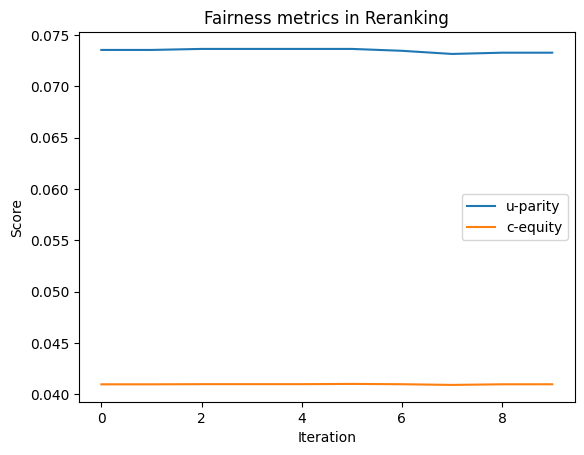

In [330]:
df_result[['u-parity','c-equity']].plot(xlabel='Iteration', ylabel='Score', title='Fairness metrics in Reranking')

## Tests

In [252]:
user_id = 123

result = agent.invoke(
    {
        "messages": [{"role": "user", "content": f"Recommend movies for the user {user_id}"}],
    },
    config=config,
    context=UserContext(user_id=user_id,session_id=experiment_id),
    
)

print(result['messages'][-1].pretty_print())

[FilterCandidateSet] User[123], Model: ease, Top K: 20[GetUserHistory] user_id: 123

[GetUserPreferences] User[123] history length: 845
[CheckRecommendations] User[123] - Recommendations length: 10
[CheckRecommendations] User[123] - Recommendations length: 10
[CheckRecommendations] User[123] - Recommendations length: 10
 --- GetMetrics --- [123]@10 (backbone_model=ease)
Metrics@2: C-Equity: 0.0410 (±0.0425), U-Parity: 0.07354651425993249 (±0.05442441471627253)
================================= Tool Message =================================
Name: RecommendationResponse

Returning structured response: user_id=123 recommendations=['The Green Mile', 'The Silence of the Lambs', 'GoodFellas', 'The Shawshank Redemption', 'Pulp Fiction', 'The Usual Suspects', 'Fight Club', 'Requiem for a Dream', 'L.A. Confidential', 'Donnie Brasco']
None


In [ ]:
namespace_for_memory = (str(user_id),"recommendations")
store.get(namespace_for_memory,experiment_id)

Item(namespace=['123', 'recommendations'], key='1', value={'recommended_items': ['Green Mile, The (1999)', 'Silence of the Lambs, The (1991)', 'GoodFellas (1990)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Usual Suspects, The (1995)', 'Fight Club (1999)', 'Requiem for a Dream (2000)', 'L.A. Confidential (1997)', 'Donnie Brasco (1997)']}, created_at='2025-11-24T01:30:56.539461+00:00', updated_at='2025-11-24T01:30:56.539462+00:00')

In [266]:
namespace_for_memory = (str(user_id),)
store.search(namespace_for_memory)

[Item(namespace=['9', 'preferences'], key='1', value={'infered_preferences': 'Based on your watched movies, you seem to prioritize the following features in your movie preferences:\n\n1. **Genre Diversity with a Focus on Action, Adventure, and Sci-Fi:** You enjoy high-energy films like *Die Hard*, *The Terminator*, and *Star Wars*, indicating a taste for action-packed and adventurous stories. Sci-fi classics like *The Matrix*, *Twelve Monkeys*, and *Contact* also appeal to you, suggesting an interest in futuristic and speculative themes.\n\n2. **Mix of Humor and Light-hearted Elements:** Films such as *Ghostbusters*, *Sister Act 2*, *The Love Bug*, and *Shall We Dance?* suggest you enjoy movies that combine comedy, music, and uplifting vibes.\n\n3. **Drama and Thought-Provoking Content:** You seem to appreciate films that explore human stories and deeper themes, like *Good Will Hunting*, *Dead Poets Society*, and *The Sixth Sense*, indicating an interest in emotionally engaging and psy

In [277]:
namespace_for_memory = ("metrics","c-equity")
store.search(namespace_for_memory)

[Item(namespace=['metrics', 'c-equity'], key='1', value={'mean': 0.04095798440697764, 'std': 0.04251155367150264}, created_at='2025-11-24T01:30:32.042576+00:00', updated_at='2025-11-24T01:30:32.042576+00:00', score=None),
 Item(namespace=['metrics', 'c-equity'], key='2', value={'mean': 0.04095798440697764, 'std': 0.04252643810267245}, created_at='2025-11-24T01:30:59.191854+00:00', updated_at='2025-11-24T01:30:59.191855+00:00', score=None),
 Item(namespace=['metrics', 'c-equity'], key='3', value={'mean': 0.04097282560614654, 'std': 0.04254220934442971}, created_at='2025-11-24T01:36:20.796131+00:00', updated_at='2025-11-24T01:36:20.796132+00:00', score=None),
 Item(namespace=['metrics', 'c-equity'], key='4', value={'mean': 0.04097282560614654, 'std': 0.04254220934442971}, created_at='2025-11-24T01:41:22.242592+00:00', updated_at='2025-11-24T01:41:22.242593+00:00', score=None),
 Item(namespace=['metrics', 'c-equity'], key='5', value={'mean': 0.04097282560614654, 'std': 0.04254220934442971

In [278]:
namespace_for_uparity = ("metrics","u-parity")
store.search(namespace_for_uparity)

[Item(namespace=['metrics', 'u-parity'], key='1', value={'mean': 0.07354651425993247, 'std': 0.0542062592059169}, created_at='2025-11-24T01:30:32.042580+00:00', updated_at='2025-11-24T01:30:32.042580+00:00', score=None),
 Item(namespace=['metrics', 'u-parity'], key='2', value={'mean': 0.07354651425993249, 'std': 0.05442441471627253}, created_at='2025-11-24T01:30:59.191859+00:00', updated_at='2025-11-24T01:30:59.191859+00:00', score=None),
 Item(namespace=['metrics', 'u-parity'], key='3', value={'mean': 0.07364545558772512, 'std': 0.05442334470000494}, created_at='2025-11-24T01:36:20.796136+00:00', updated_at='2025-11-24T01:36:20.796136+00:00', score=None),
 Item(namespace=['metrics', 'u-parity'], key='4', value={'mean': 0.07364545558772512, 'std': 0.05442334470000494}, created_at='2025-11-24T01:41:22.242596+00:00', updated_at='2025-11-24T01:41:22.242597+00:00', score=None),
 Item(namespace=['metrics', 'u-parity'], key='5', value={'mean': 0.07364545558772512, 'std': 0.05442334470000494}

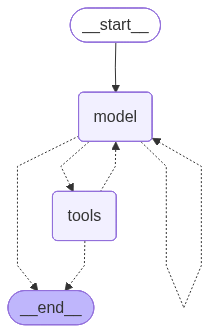

In [29]:
agent

# Print all messages in the result
for message in result['messages']:
    print(message.pretty_print())

In [118]:
result['structured_response']

RecommendationResponse(user_id=123, recommendations=['Back to the Future', "Pee-wee's Big Adventure", 'Forrest Gump', 'The Shawshank Redemption', 'The Silence of the Lambs', 'The Usual Suspects', 'The Sixth Sense', 'Apollo 13', "Jacob's Ladder", 'GoodFellas'])

In [119]:
result['preferences']

'Based on your watchlist, your key preferences seem to include:\n\n1. **Diverse Genres with a Focus on Drama and Thriller:** You enjoy intense narratives, from psychological thrillers (The Silence of the Lambs, The Sixth Sense) to crime and noir (Fargo, Reservoir Dogs, L.A. Confidential).\n\n2. **Strong Character Development and Emotional Depth:** Films like Forrest Gump, Schindler’s List, The Green Mile, and Saving Private Ryan showcase a preference for emotionally compelling stories with memorable characters.\n\n3. **Clever, Thought-Provoking, and Stylish Films:** You appreciate movies with unique storytelling, like Being John Malkovich, Pulp Fiction, Run Lola Run, and The Matrix.\n\n4. **Humor and Quirky Elements:** You include comedies and offbeat films such as Pee-wee’s Big Adventure, Grosse Pointe Blank, Friday, and Clerks, indicating an appreciation for humor and eccentricity.\n\n5. **Awards and Critical Acclaim:** Many of your picks are critically acclaimed or award-winning, re

# Discussed on last meeting

Goal: given a set of users, produce a set of k fair recommendations for each user.

Variant: individual fairness

Variant 1: no fairness + individual

variant2: memory+holistic fairness

-----

Variant2: holistic and no memory

Verify if an LLM is able to enforce fairness

Verify an LLM is able to enforce fairness holistically or individually

Impact of memory on the LLM’s ability to enforce fairness


-> Implementar o componente de memória
-> Pensar em como estruturar os prompts para cada variante com base na memória


In [121]:
resp : RecommendationResponse = result['structured_response']
resp

RecommendationResponse(user_id=123, recommendations=['Back to the Future', "Pee-wee's Big Adventure", 'Forrest Gump', 'The Shawshank Redemption', 'The Silence of the Lambs', 'The Usual Suspects', 'The Sixth Sense', 'Apollo 13', "Jacob's Ladder", 'GoodFellas'])

In [126]:
raw_target_user_id = get_raw_user_ids(ratings_pp, [resp.user_id])[0]
test_ratings[test_ratings.User_id == raw_target_user_id]


,User_id,Item_id,Rating,Timestamp,Gender,datetime
